<a href="https://colab.research.google.com/github/teegwende/WQPandEntitiesDensity/blob/main/evaluationModel_ParamsSaufFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
from pandas import read_csv, DataFrame
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
  

######################################################## CHOIX DATASET #############################################################
jeu_donnees=int(input('1-jeu Panamasso 2-UCAD 3-Compaore'))
if jeu_donnees==1:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/feed_new.csv', index_col='DATE', parse_dates=True)
    df=df.drop(columns=['entry_id','latitude','longitude','elevation','status'])
if jeu_donnees==2:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/data_ucad.csv', index_col='DATE', parse_dates=True)

if jeu_donnees==3:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/etude_de_compaore2 .csv', index_col='DATE', parse_dates=True)
    #df=df.drop(columns=['entry_id','latitude','longitude','elevation','status'])

######################################################"PREPROCESSING##################################################################
##########################################ELIMINATION VALEURS ABERRANTES##############################################################
#évaluation des plages des valeurs 
plage = {"PH":[0,14],
        "TEMP":[0,60],
         "EC":[0,20000], #muS/cm
         "DO" :[-1,50],
         
         } 
#dataparams = list()
dataparams={}  # Noter que l'algo est de créer un dico avec comme clé chaque param
for col in df.columns:
    if not plage.get(col)==None:
        sub=df.loc[ ~ (  (df[col]<=plage.get(col)[0])  | (df[col]>=plage.get(col)[1]) ) ][col]
        dataparams[col]=sub


####################################################DIFFRENTES FONCTIONS#########################################################
###############################################FONCTION IMPUTATION##############################################################
import numpy as np
import math 
from pandas import concat

def imputation(ledataframe):
    params=["PH","TEMP","DO","EC"]
    cols=list()
    for param in params:
        data=dataparams.get(param).resample('D').mean()
        i=0
        j=0
        for index, row in data.items():   
            if(i==data.size):
                break
            if math.isnan(data.iloc[i]):
                val1=data.iloc[i-1] #On stocke la premiere valeur de calcul de la moyenne
                j=i
                while math.isnan(data.iloc[j]): #on saute toutes les autres valeurs nan
                    j=j+1
                val2=data.iloc[j]
                k=i
                while k<j: #on remonte pour remplacer les valeurs nan par la moyenne
                    data.iloc[k]=(val1+val2)/2
                    k=k+1
                i=j #i redevient j pour qu'on continue avec les valeurs suivantes
            else:
                i=i+1
        cols.append(data)
    agg=concat(cols,axis=1)
    agg.columns=params
    return agg
  

###############################################FONCTION DIVISION DES DONNEES###########################################################
def diviserdata(periode,donnees):
  train,test=donnees.loc[donnees.index < periode],donnees.loc[donnees.index> periode]
  return train,test

train_PersoImput, test_PersoImput=diviserdata("06-2017",imputation(pd.DataFrame(dataparams).resample('D').mean()))
#train_PersoImput.loc[train_PersoImput.index == '01-2019'
#train_PersoImput.loc['01-2019'].head(2)

1-jeu Panamasso 2-UCAD 3-Compaore3


In [5]:
###############################################DIFFRENTES FONCTIONS SUITE########################################################
###############################################FONCTION NORMALISATION############################################################

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # instance de la classe MinMaxScaler
#scaler = StandardScaler() # instance de la classe MinMaxScaler
#scaler = RobustScaler() # instance de la classe MinMaxScaler
#Normalization process
def normaliser(donnees):
    resultat = scaler.fit_transform(donnees) #transformation du dataset via une méthode de l'instance de MinMaxScaler
    #test_temp = scaler.fit_transform(test_temp)
    return resultat

########################################FONCTION TRANSFORMATION FORMAT SUPERVISE#################################################
#Préparation des données à entrainer
#Transformation des series temporelles en jeu de donnees supervisee 
#times series vers cross-sectional data (c'est un peu les termes techniques)
from pandas import concat
def preparationData(donnees, nbValPrec=1, nbValSuiv=1,dropnan=True):
    #params=["ind0","ind1","DATE","PH","TEMP"]
    params=["DATE","PH","TEMP","DO","EC"]
    #params=["PH","TEMP"]
    n_vars = 1 if type(donnees) is list else donnees.shape[1]
    df = DataFrame(donnees)
    newdf=df.reset_index(drop=False)
    #print(newdf)
    cols, names = list(), list()
    #Les valeurs précédentes à considérer
    for i in range(nbValPrec, 0, -1):
        cols.append(newdf.shift(i))
        #param='TEMP'
        #names += [('temp%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [(param+'(t-%d)' % (i)) for param in params ]
    #La longueur de prédiction
    for i in range(0, nbValSuiv):
        cols.append(newdf.shift(-i))
        if i == 0:
            #names += [('temp%d(t)' % (j+1)) for j in range(n_vars)]
            names += [(param+'(t)') for param in params ]
        else:
            #names += [('temp%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            names += [(param+'(t+%d)' % (i)) for param in params ]
    #Le dataset final
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

###############################################FONCTION COMPELTION DATA COEF WAVELET##########################################################
#Algo pour compléter un nombre pour obtenir le multiple de son diviseur
#Récupérer le reste de la division
#Soustraire le reste du coeficient
#additionner le resultat de la soustraction au nombre initial
# Import math Library
import math 
def completerData(donnees):
    level=3
    nombredezeros= int(math.pow(2,level))- ( len(donnees) % int(math.pow(2,level))   )
    pad_arr = np.pad(donnees, (0,nombredezeros), 'constant', constant_values=(0))
    return pad_arr

###############################################FONCTION FORMATION DATASET POUR WANN ##########################################################
#Elabaration du newinput
import pywt
from pandas import concat
def createnewinput(donnees,wavelet,level):
    newinput=list()
    for i in range(donnees.shape[1]):
        newdf=completerData(donnees[:, i]) #il complète le nombre de zéros nécessaires
        #coefswt=pywt.swt(newdf,'haar',level=3,norm=True,axis=0) #ici il calcule les coefficients
        coefswt=pywt.swt(newdf,wavelet,level=level,norm=True,axis=0) #ici il calcule les coefficients
        newinput.append(pd.Series(coefswt[0][0]))
        for coef in coefswt:
            newinput.append(pd.Series(coef[1]))
    agg=concat(newinput,axis=1)
    return agg

import keras
from keras.layers import Dense,Activation,Flatten
from keras.models import Sequential

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

##############################################FONCTIONS DE VISUALISATION DES RESULTATS #############################################""
def visualPrediction(param,periode,donneestest,donneesPredite,nb_obs,horizon,nbrefois,directory):
  interval=1
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(pd.to_datetime(periode),donneestest,'o-',label='Donnees Test')
  
  for v,p in zip(donneestest,periode):
    if interval==30 or interval==60 or interval==84:
      ax.annotate(round(v,2),xy=(p,v),fontsize=10)
    interval=interval+1

  ax.plot(pd.to_datetime(periode),donneesPredite,'o-',label='Donnes Predites')

  interval=1

  for v,p in zip(donneesPredite,periode):
    if interval==30 or interval==60 or interval==84:
      ax.annotate(round(v,2),xy=(p,v),fontsize=10)
    interval=interval+1

  ax.set(xlabel="Date", ylabel=param,
       title="WANN"+" "+param+" Lag"+str(nb_obs)+" Horizon="+str(horizon))
  ax.legend()

  # Format the x axis
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
  #ax.xaxis.set_major_locator(mdates.DayLocator(30))
  #ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
  plt.xticks(rotation=45, ha='right',fontsize=14)
  #plt.xlim(periode[0],periode[20])
  plt.savefig(directory+"WANN"+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+param+'.pdf')

  plt.show()
  plt.close()

####Noter que dans cette fonction, on peut juste retenir la dernière colonne de l'horizon recherché
###Tout comme on peut plotter toutes les valeurs prédites de depuis parm (t) jusqu'à parm(t-+horzion-1)
def visualCalibrationPlot(param,donneestest,donneesPredite,nbrefois,directory,periode):
 
  plt.figure(figsize=(15,6))
  #plt.plot(donneestest[-len(periode):],donneestest[-len(periode):],c='black')
  #plt.scatter(donneestest[-len(periode):],donneesPredite[-len(periode):],c='blue',alpha=0.6)
  plt.plot(donneestest,donneestest,c='black')
  plt.scatter(donneestest,donneesPredite,c='blue',alpha=0.6)
  plt.xlabel(param+" Attendue")
  plt.ylabel(param+" Prédite")
  plt.savefig(directory+"WANN"+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+param+'.pdf')
  plt.show()
  plt.legend(loc=0)
  plt.close()

In [6]:
mesdata=preparationData(train_PersoImput,20,90)
mesdata
# mesdata=preparationData(train_PersoImput,2,1)
# mesdata.loc[:,mesdata.columns.str.contains("DATE\(t\-|DATE\(t\)")].loc[214:214:,]
#mesdata.loc[53:53,]
# mesdata

,DATE(t-20),PH(t-20),TEMP(t-20),DO(t-20),EC(t-20),DATE(t-19),PH(t-19),TEMP(t-19),DO(t-19),EC(t-19),...,DATE(t+88),PH(t+88),TEMP(t+88),DO(t+88),EC(t+88),DATE(t+89),PH(t+89),TEMP(t+89),DO(t+89),EC(t+89)
20,2016-06-01,7.000,27.000,48.000,60.000,2016-06-02,7.000,27.000,48.000,60.000,...,2016-09-17,7.000,27.000,48.000,60.000,2016-09-18,7.000,27.000,48.000,60.000
21,2016-06-02,7.000,27.000,48.000,60.000,2016-06-03,7.000,27.000,48.000,60.000,...,2016-09-18,7.000,27.000,48.000,60.000,2016-09-19,7.000,27.000,48.000,60.000
22,2016-06-03,7.000,27.000,48.000,60.000,2016-06-04,7.000,27.000,48.000,60.000,...,2016-09-19,7.000,27.000,48.000,60.000,2016-09-20,7.000,27.000,48.000,60.000
23,2016-06-04,7.000,27.000,48.000,60.000,2016-06-05,7.000,27.000,48.000,60.000,...,2016-09-20,7.000,27.000,48.000,60.000,2016-09-21,7.000,27.000,48.000,60.000
24,2016-06-05,7.000,27.000,48.000,60.000,2016-06-06,7.000,27.000,48.000,60.000,...,2016-09-21,7.000,27.000,48.000,60.000,2016-09-22,7.000,27.000,48.000,60.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2017-02-07,7.000,24.000,41.500,125.000,2017-02-08,7.000,24.000,41.500,125.000,...,2017-05-26,6.000,27.000,35.000,220.000,2017-05-27,6.000,27.000,35.000,220.000
272,2017-02-08,7.000,24.000,41.500,125.000,2017-02-09,7.000,24.000,41.500,125.000,...,2017-05-27,6.000,27.000,35.000,220.000,2017-05-28,6.000,27.000,35.000,220.000
273,2017-02-09,7.000,24.000,41.500,125.000,2017-02-10,7.000,24.000,41.500,125.000,...,2017-05-28,6.000,27.000,35.000,220.000,2017-05-29,6.000,27.000,35.000,220.000
274,2017-02-10,7.000,24.000,41.500,125.000,2017-02-11,7.000,24.000,41.500,125.000,...,2017-05-29,6.000,27.000,35.000,220.000,2017-05-30,6.000,27.000,35.000,220.000


In [25]:
donnees_train=train_PersoImput 
donnees_test=test_PersoImput
# nb_obs=10
# horizon=84
nb_obs=20
horizon=90
n_features=4

wavelet="haar"
level=3

train=preparationData(donnees_train,nb_obs,horizon)

train_dates=train.loc[:, train.columns.str.contains("DATE\(t\+|DATE\(t\)")]
train=train.loc[:,~train.columns.str.contains("DATE")]

#ligne=273 #Correspond aux 10 derniers jours du mois de février donc saison froide
ligne= 214# Correspond aux 10 derniers jours de décembre, donc saison froide. Mieux adapté car la période de collecte était Décembre. 
          # Les prédictions doivent nous conduire vers le mois de janvier février Mars. C'est Mars qui nous intéresse (correspond à la période chaude)
test2=train.loc[ligne:ligne:,]
test_dates2=train_dates.loc[ligne:ligne:,]

print("dates =",test_dates2)
#Subdivision en X et y

X_test2,y_test2 = test2.iloc[:,:nb_obs*n_features].values,test2.iloc[:, -horizon*n_features:].values
print("X_test2",X_test2)


X_test2=normaliser(X_test2)
y_test2=normaliser(y_test2)

methode=int(input("1-WANN 2-LSTM 3-SVR"))

if methode==1:
  print("X_test2 normaliser",X_test2)
  X_test2=createnewinput(X_test2,wavelet,level)
  X_test2=X_test2.values

if methode==2:
  X_test2=X_test2.reshape(X_test2.shape[0],1,nb_obs*n_features)

if methode==3:
  X_test2=X_test2
  
print("y_test2",y_test2)

dates =        DATE(t)  DATE(t+1)  DATE(t+2)  DATE(t+3)  DATE(t+4)  DATE(t+5)  \
214 2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05 2017-01-06   

     DATE(t+6)  DATE(t+7)  DATE(t+8)  DATE(t+9)  ... DATE(t+80) DATE(t+81)  \
214 2017-01-07 2017-01-08 2017-01-09 2017-01-10  ... 2017-03-22 2017-03-23   

    DATE(t+82) DATE(t+83) DATE(t+84) DATE(t+85) DATE(t+86) DATE(t+87)  \
214 2017-03-24 2017-03-25 2017-03-26 2017-03-27 2017-03-28 2017-03-29   

    DATE(t+88) DATE(t+89)  
214 2017-03-30 2017-03-31  

[1 rows x 90 columns]
X_test2 [[  7.   24.   41.5 125.    7.   24.   41.5 125.    7.   24.   41.5 125.
    7.   24.   41.5 125.    7.   24.   41.5 125.    7.   24.   41.5 125.
    7.   24.   41.5 125.    7.   24.   41.5 125.    7.   24.   41.5 125.
    7.   24.   41.5 125.    7.   24.   41.5 125.    7.   24.   41.5 125.
    7.   24.   41.5 125.    7.   24.   41.5 125.    7.   24.   41.5 125.
    7.   24.   41.5 125.    7.   24.   41.5 125.    7.   24.   41.5 125.
    7.   24.   4

In [26]:
#cheminmodel='21_Jun_2022_11_30/WANN_nbObs2_H1/
#cheminmodel='22_Jun_2022_23_02/WANN_nbObs4_H7/'
#cheminmodel='23_Jun_2022_10_50/WANN_nbObs4_H14/'
# cheminmodel='23_Jun_2022_12_06/WANN_nbObs4_H28/'
#cheminmodel='23_Jun_2022_12_37/WANN_nbObs4_H84/'
# cheminmodel='07_Jul_2022_13_05/WANN_nbObs10_H84/'
# cheminmodel='02_Aug_2022_16_08/WANN_nbObs2_H1'
cheminmodel='05_Aug_2022_23_23/WANN_nbObs20_H90/'
# cheminmodel='05_Aug_2022_23_23/LSTM_nbObs20_H90/'

model = keras.models.load_model('/gdrive/MyDrive/traitement_ordinaire/'+cheminmodel)
predictions=model.predict(X_test2[:len(y_test2)])
# predictions=model.predict(X_test2)

In [27]:
predictions

array([[ 0.05161786,  0.02227216,  0.0137438 ,  0.02780003,  0.04624853,
         0.00946974,  0.00690431,  0.02833058,  0.04250178,  0.01948718,
         0.0035108 ,  0.02564142,  0.04934911,  0.01841378, -0.00932645,
         0.03957883,  0.03767885,  0.0073957 ,  0.00712692,  0.03413095,
         0.05127959,  0.01454416, -0.00846378,  0.03629756,  0.05038144,
         0.01400186,  0.00879593,  0.03334637,  0.0450942 ,  0.01969992,
         0.02448084,  0.04559818,  0.04691577,  0.02217459,  0.015993  ,
         0.04037856,  0.0383933 ,  0.02799531,  0.01679788,  0.05132363,
         0.04555938,  0.02199829,  0.01837934,  0.05257195,  0.03354096,
         0.02538748,  0.02198014,  0.04957197,  0.03565701,  0.0301965 ,
         0.02048412,  0.04314836,  0.02557784,  0.0258023 ,  0.00489016,
         0.05056179,  0.03301289,  0.02499093,  0.02544018,  0.05743635,
         0.03681242,  0.02146375,  0.02115141,  0.05254328,  0.03114178,
         0.01630565,  0.00881493,  0.03186817,  0.0

In [28]:
predictions=scaler.inverse_transform(predictions) 
y_test2=scaler.inverse_transform(y_test2)
print(predictions)
print(y_test2)

[[  7.0516176  24.022272   41.513744  125.0278      7.0462484  24.00947
   41.506905  125.02833     7.042502   24.019487   41.50351   125.02564
    7.0493493  24.018414   41.490673  125.03958     7.0376787  24.007395
   41.507126  125.034134    7.0512795  24.014544   41.491535  125.0363
    7.0503817  24.014002   41.508797  125.03335     7.045094   24.0197
   41.524483  125.0456      7.0469155  24.022175   41.51599   125.040375
    7.0383935  24.027996   41.516796  125.05132     7.0455594  24.021997
   41.51838   125.052574    7.0335407  24.025387   41.52198   125.04957
    7.035657   24.030197   41.520485  125.04315     7.025578   24.025803
   41.50489   125.05056     7.033013   24.02499    41.52544   125.057434
    7.0368123  24.021463   41.521152  125.05254     7.0311418  24.016306
   41.508816  125.03187     7.0567646  24.019552   41.522873  125.04825
    7.0511727  24.012186   41.494354  125.05192     7.036584   24.02788
   41.511703  125.04091     7.035238   24.027798   41.510166

y_test2 (1, 360)
y_test2     0      1      2       3     4      5      6       7     8      9    ...  \
0 7.000 24.000 41.500 125.000 7.000 24.000 41.500 125.000 7.000 24.000  ...   

     350     351   352    353    354     355   356    357    358     359  
0 35.000 220.000 6.000 27.000 35.000 220.000 6.000 27.000 35.000 220.000  

[1 rows x 360 columns]
les dates taille 1


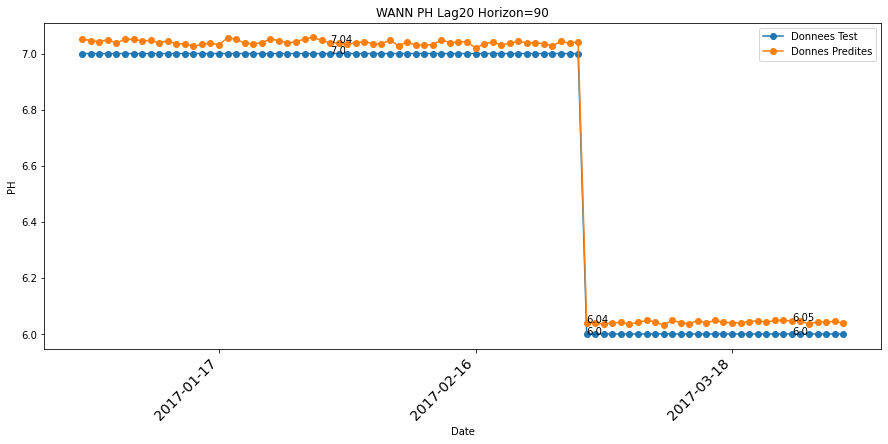

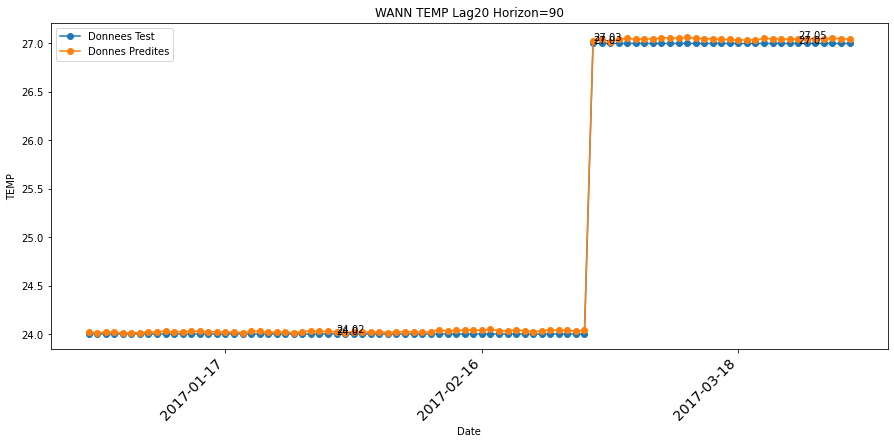

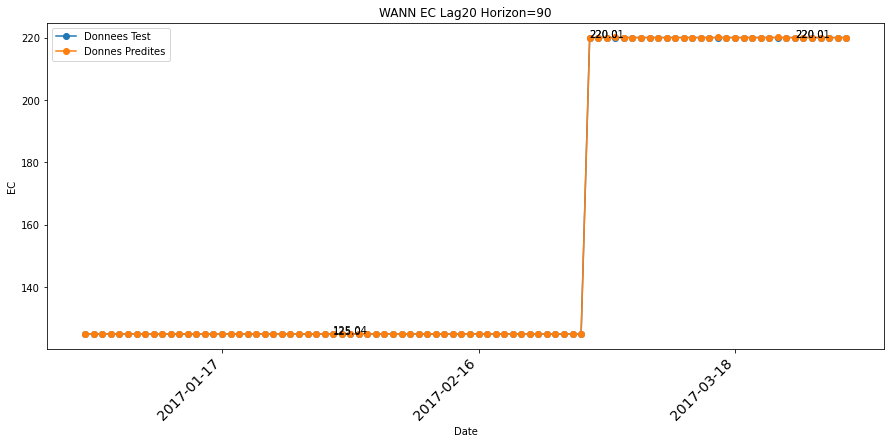

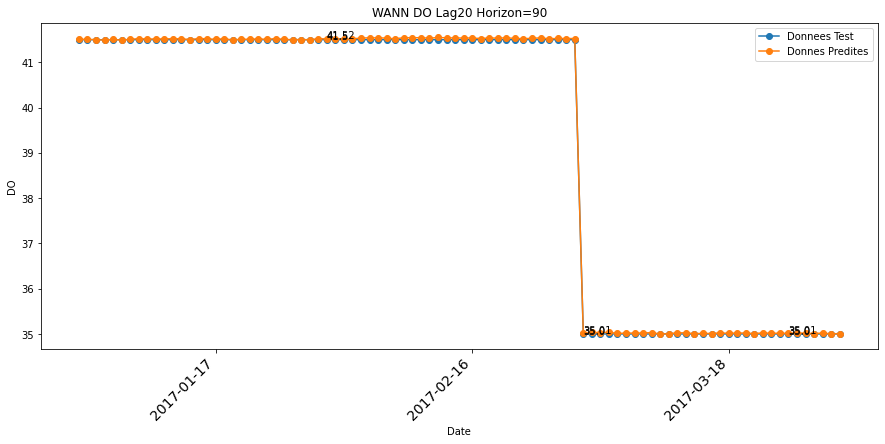

[[41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5
  41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5
  41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5
  41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5 41.5
  41.5 41.5 41.5 35.  35.  35.  35.  35.  35.  35.  35.  35.  35.  35.
  35.  35.  35.  35.  35.  35.  35.  35.  35.  35.  35.  35.  35.  35.
  35.  35.  35.  35.  35.  35. ]]


In [29]:
import os
from datetime import datetime, timedelta

nbrefois=1
#Création du dossier des graphes
now = datetime.now()
directory=str('/gdrive/MyDrive/traitement_ordinaire/' +str( now.strftime(("%d_%b_%Y_%H_%M")) ) )
if not os.path.exists(directory):
    os.mkdir(directory)

predictions=pd.DataFrame(predictions)
y_test2=pd.DataFrame(y_test2)
      
predictionPH=pd.DataFrame()
y_testPH=pd.DataFrame()
predictionTemp=pd.DataFrame()
y_testTemp=pd.DataFrame()
predictionDO=pd.DataFrame()
y_testDO=pd.DataFrame()
predictionEC=pd.DataFrame()
y_testEC=pd.DataFrame()

if horizon==1:
  lesdates= test_dates2.loc[:, test_dates2.columns.str.contains("DATE\(t\)")]
else:
  #lesdates= test_dates2.loc[:, test_dates2.columns.str.contains("DATE\(t\+"+str(horizon-1)+"\)")] 
  lesdates= test_dates2.loc[:, test_dates2.columns.str.contains("DATE\(t\+|DATE\(t\)")] 


print("y_test2",y_test2.shape)
print("y_test2",y_test2.head(10))
print("les dates taille",len(lesdates))
for ii in range(0,y_test2.shape[1],4):
  predictionPH=pd.concat([predictionPH, predictions.iloc[:,ii]],axis=1)
  y_testPH=pd.concat([y_testPH, y_test2.iloc[:,ii]],axis=1)

  predictionTemp=pd.concat([predictionTemp, predictions.iloc[:,ii+1]],axis=1)
  y_testTemp=pd.concat([y_testTemp, y_test2.iloc[:,ii+1]],axis=1)

  predictionDO=pd.concat([predictionDO,predictions.iloc[:,ii+2]],axis=1)
  y_testDO=pd.concat([y_testDO,y_test2.iloc[:,ii+2]],axis=1)

  predictionEC=pd.concat([predictionEC,predictions.iloc[:,ii+3]],axis=1)
  y_testEC=pd.concat([y_testEC, y_test2.iloc[:,ii+3]],axis=1)

# for ii in range( y_test2.shape[1]):
#   if ii%2==0: #Pour séparer les températures des ph
#     predictionPH=pd.concat([predictionPH, predictions.iloc[:,ii]],axis=1)
#     y_testPH=pd.concat([y_testPH, y_test2.iloc[:,ii]],axis=1)
#   else:
#     predictionTemp=pd.concat([predictionTemp, predictions.iloc[:,ii]],axis=1)
#     y_testTemp=pd.concat([y_testTemp, y_test2.iloc[:,ii]],axis=1)


# testdf=pd.DataFrame(predictionTemp.values.reshape(-1),index=lesdates.values.reshape(-1))
# print(testdf.resample('30D').mean())
# testdf.resample('30D').mean().plot()

directoryPredict=directory+"/PredictionPlot/"
if not os.path.exists(directoryPredict):
  os.mkdir(directoryPredict)


predictionPH.transpose().to_csv(directory+'/PH_.csv')
predictionTemp.transpose().to_csv(directory+'/Temp.csv')
predictionEC.transpose().to_csv(directory+'/Ec.csv')
predictionDO.transpose().to_csv(directory+'/Do.csv')

lesdates.transpose().to_csv((directory+'/lesdates.csv'))
# visualPrediction("PH",lesdates.values.reshape(-1) ,y_testPH.iloc[:,horizon-1].values.reshape(-1),predictionPH.iloc[:,horizon-1].values.reshape(-1),
#                  nb_obs,horizon,nbrefois,directoryPredict)
# visualPrediction("TEMP",lesdates.values.reshape(-1) ,y_testTemp.iloc[:,horizon-1].values.reshape(-1),predictionTemp.iloc[:,horizon-1].values.reshape(-1),
# nb_obs,horizon,nbrefois,directoryPredict)

visualPrediction("PH",lesdates.values.reshape(-1) ,y_testPH.values.reshape(-1),predictionPH.values.reshape(-1),
                  nb_obs,horizon,nbrefois,directoryPredict)
visualPrediction("TEMP",lesdates.values.reshape(-1) ,y_testTemp.values.reshape(-1),predictionTemp.values.reshape(-1),
nb_obs,horizon,nbrefois,directoryPredict)
visualPrediction("EC",lesdates.values.reshape(-1) ,y_testEC.values.reshape(-1),predictionEC.values.reshape(-1),
                  nb_obs,horizon,nbrefois,directoryPredict)
visualPrediction("DO",lesdates.values.reshape(-1) ,y_testDO.values.reshape(-1),predictionDO.values.reshape(-1),
nb_obs,horizon,nbrefois,directoryPredict)
        
directoryCalibration=directory+"/CalibrationPlot/"
if not os.path.exists(directoryCalibration):
  os.mkdir(directoryCalibration)

print(y_testDO.values)
# visualCalibrationPlot("PH",y_testPH.values.reshape(-1)[len(y_test2)],predictionPH.values.reshape(-1)[len(y_test2)],nbrefois,directoryCalibration,lesdates.values.reshape(-1)[len(y_test2)])
# visualCalibrationPlot("TEMPERATURE",y_testTemp.values.reshape(-1)[len(y_test2)],predictionTemp.values.reshape(-1)[len(y_test2)],nbrefois,directoryCalibration,lesdates.values.reshape(-1)[len(y_test2)])
# visualCalibrationPlot("CONDUCTIVITE ELECTRIQUE",y_testEC.values.reshape(-1)[len(y_test2)],predictionEC.values.reshape(-1)[len(y_test2)],
                      # nbrefois,directoryCalibration,lesdates.values.reshape(-1)[len(y_test2)])
# visualCalibrationPlot("OXYGENE DISSOUS",y_testDO.values.reshape(-1)[len(y_test2)],predictionDO.values.reshape(-1)[len(y_test2)],
                      # nbrefois,directoryCalibration,lesdates.values.reshape(-1)[len(y_test2)])


In [30]:
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, r2_score
from math import sqrt 

#Calcul des métriques
rmse = sqrt(mean_squared_error(predictions, y_test2))
mae = mean_absolute_error(predictions, y_test2)
r2=r2_score(predictions, y_test2)
print("rmse=",rmse)
print("mae=",mae)
print("r2=",r2)


rmse= 0.034231405032805425
mae= 0.031389379501342775
r2= nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
